# A/B-тестирование платёжной воронки

В проекте представлен анализ результатов A/B-теста пользователей новой платёжной воронки сайта интернет-магазина на основании данных о регистрациях, действиях, групп пользователей и маркетинговых активностях. <br>
<br>
<b> Задачи проекта: </b> <br>
- провести оценку результатов A/B-теста на соответствие Техническому заданию<br>
- оценить, достаточно ли кол-во участников теста для достижения статистической значимости различий групп <br>
- проанализировать результаты конверсии по воронке продаж у групп теста <br>
- оценить статистическую значимость различий в долях конверсии у групп теста<br>

<b>Содержание проекта:</b><br>
1. Общая информация<br>
2. Предобработка<br>
3. Исследовательский анализ<br>
4. Анализ результатов А/В-теста <br>
5. Анализ статистической значимости <br>
6. Общий вывод<br>

### Общая информация

In [1]:
# загрузка необходимых библиотек
import pandas as pd
import numpy as np
from datetime import datetime as dt
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from plotly.subplots import make_subplots

<b>  Техническое задание А/В-теста: </b> <br>
- Название теста: `recommender_system_test`;<br>
- группы: А — контрольная, B — новая платёжная воронка;<br>
- дата запуска: 2020-12-07;<br>
- дата остановки набора новых пользователей: 2020-12-21;<br>
- дата остановки: 2021-01-04;<br>
- аудитория: 15% новых пользователей из региона EU;<br>
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;<br>
- ожидаемое количество участников теста: 6000.<br>
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:<br>
    - конверсии в просмотр карточек товаров — событие `product_page`<br>
    - просмотры корзины — `product_cart`<br>
    - покупки — `purchase`

<b>  Описание данных: </b> <br>
<br>
`users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года:<br>
- `user_id` — идентификатор пользователя;<br>
- `first_date` — дата регистрации;<br>
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.<br>
<br>
`events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:.<br>
- `user_id` — идентификатор пользователя;<br>
- `event_dt` — дата и время события;<br>
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, <br>
`purchase,` в этом поле хранится стоимость покупки в долларах.<br>
<br>
`test.csv` — таблица участников тестов:<br>
- `user_id` — идентификатор пользователя;<br>
- `ab_test` — название теста;<br>
- `group` — группа пользователя.<br>

In [2]:
# загрузка данных
users = pd.read_csv('users.csv')
events = pd.read_csv('events.csv')
participants = pd.read_csv('test.csv')

### Предобработка

In [3]:
# анализ данных, нахождение пропусков и дубликататов в датасете marketing
#users.info()
#print('Кол-во пропусков:', users.isna().sum())
#print('Кол-во дубликатов:',users.duplicated().sum())
#events.info()
#print('Кол-во пропусков:')
#print(events.isna().sum())
#print('Кол-во дубликатов:', events.duplicated().sum())
#participants.info()
#print('Кол-во пропусков:')
#print(participants.isna().sum())
#print('Кол-во дубликатов:', participants.duplicated().sum())

In [4]:
# переименование столбца на registation_date
users = users.rename(columns={"first_date": "registation_date"})

In [5]:
# перевод даты в формат datetime и дату
users['registation_date'] = pd.to_datetime(users['registation_date'], format='%Y-%m-%d').dt.date
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')
# создание отдельного столбца даты без времени
events['event_date'] = events['event_dt'].dt.date

<b>Выводы:</b> <br>
Проведена предобработка датасета: <br>
- проведена проверка датасета на явные дубликаты: не выявлено  <br>
- проведена проверка датасета на пропуски: пропущенные значения выявлены для датасета events, наличие пропусков по столбцу 'details' корректно типу информации в данном столбце <br> 
- изменены типы данных на datetime <br>

### Исследовательский анализ

####  Анализ структуры данных

In [6]:
# анализ данных по категориям, событиям и группам, представленным в датасетах
print('Регионы новых пользователей:', users['region'].unique())
print('Устройства новых пользователей:', users['device'].unique())
print('События новых пользователей:',events['event_name'].unique())
print('Распределение участников:')
display(participants.pivot_table(index = 'ab_test', columns = 'group', values = 'user_id', aggfunc = 'nunique'))

Регионы новых пользователей: ['EU' 'N.America' 'APAC' 'CIS']
Устройства новых пользователей: ['PC' 'Android' 'iPhone' 'Mac']
События новых пользователей: ['purchase' 'product_cart' 'product_page' 'login']
Распределение участников:


group,A,B
ab_test,,
interface_eu_test,5831,5736
recommender_system_test,3824,2877


<b>Выводы:</b><br>
В датасетах представленны данные:<br>
- пользователи из 4х регионов ('EU' 'N.America' 'APAC' 'CIS')<br>
- пользователи 4х устройств ('PC' 'Android' 'iPhone' 'Mac')<br>
- данные собраны по 4-м событиям: покупка ('purchase'), добавление в корзину ('product_cart'), просмотр страницы товара ('product_page'), авторизация ('login')<br>
- пользователи 2х тестов: 'interface_eu_test' и 'recommender_system_test'
- в аудитории каждого теста есть 2 группы: 'A' и 'B'

####  Анализ периода дат

In [7]:
# анализ периода дат регистрации новых пользователей
print('Минимальная дата регистрации пользователей из EU:', users['registation_date'].min())
print('Максимальная дата регистрации пользователей из EU:', users['registation_date'].max())

Минимальная дата регистрации пользователей из EU: 2020-12-07
Максимальная дата регистрации пользователей из EU: 2020-12-23


<b>Выводы:</b><br>
В датасете new_users собраны данные о регистрации пользователей с 2020-12-07 по 2020-12-23<br>
<br>
По техническому заданию дата запуска теста : 2020-12-07, дата остановки набора новых пользователей: 2020-12-21<br>
=> необходимо удалить пользователей, которые зарегистрировались после  2020-12-21

In [8]:
# фильтрация датасета new_users по дате (финальная дата регистрации = 2020-12-21)
users_filtered = users[users['registation_date'] <= dt(2020, 12, 21).date()]
print('Кол-во удаленных пользователей:', users['user_id'].nunique() - users_filtered['user_id'].nunique())
print('Кол-во удаленных пользователей,%:', round((users['user_id'].nunique() - users_filtered['user_id'].nunique()) / users['user_id'].nunique(),3))

Кол-во удаленных пользователей: 5263
Кол-во удаленных пользователей,%: 0.085


<b>Выводы:</b><br>
Из датасета users были удалены 5263 пользователя (8.5%) для соответствия Техническому заданию (дата остановки теста 2020-12-21)<br>

In [9]:
# анализ периода дат событий 
print('Минимальная дата :', events['event_date'].min())
print('Максимальная дата :', events['event_date'].max())

Минимальная дата : 2020-12-07
Максимальная дата : 2020-12-30


<b>Выводы:</b><br>
В датасете events собраны данные о действиях пользователей с 2020-12-07 по 2020-12-30<br>
<br>
По техническому заданию дата остановки А/В-теста: 2021-01-04<br>
=> события в файле events соответствуют Техническому заданию, ничего удалять не нужно

####  Анализ регионов

In [10]:
# анализ пользователей из региона EU
print('Кол-во новых пользователей из всех регионов, зарегистрировавшихся с 7 по 21 декабря 2020:', users_filtered['user_id'].nunique())
print('Кол-во новых пользователей из региона EU:', users_filtered[users_filtered['region'] == 'EU']['user_id'].nunique())
print('Доля новых пользователей из региона EU:', round(users_filtered[users_filtered['region'] == 'EU']['user_id'].nunique() / users_filtered['user_id'].nunique(),3))

Кол-во новых пользователей из всех регионов, зарегистрировавшихся с 7 по 21 декабря 2020: 56470
Кол-во новых пользователей из региона EU: 42340
Доля новых пользователей из региона EU: 0.75


<b>Выводы:</b><br>
Доля пользователей из региона EU составляет 75% от всех новых пользователей, зарегистрировавшихся с 7 по 21 декабря 2020 <br>
<br>
По техническому заданию новые пользователи должны быть из региона EU<br>
=> необходимо оставить пользователей только из региона EU

In [11]:
# добавление пользователей из региона EU в отдельную переменную
users_eu = users_filtered[users_filtered['region'] == 'EU']
# создания файла с действиями пользователей из региона EU
eu_events = users_eu.merge(events, on = 'user_id')

####   Анализ участников теста </b>

In [12]:
# объединение пользователей из региона EU с данными по группам теста и событиями в отдельную переменную
users_eu_abtest = users_eu.merge(participants, on = 'user_id')
# анализ распределения пользователей из региона EU по группам теста
display(users_eu_abtest.pivot_table(index = 'ab_test', columns = 'group', values = 'user_id', aggfunc = 'nunique'))
# анализ кол-ва участников теста 'recommender_system_test' от всех новых пользователей региона
print('Кол-во участников теста recommender_system_test:', users_eu_abtest[users_eu_abtest['ab_test'] == 'recommender_system_test']['user_id'].nunique())
print('Доля участников теста recommender_system_test от новых пользователей региона EU:', round(users_eu_abtest[users_eu_abtest['ab_test'] == 'recommender_system_test']['user_id'].nunique() / users_eu['user_id'].nunique(),3))

group,A,B
ab_test,,
interface_eu_test,5342,5223
recommender_system_test,3634,2717


Кол-во участников теста recommender_system_test: 6351
Доля участников теста recommender_system_test от новых пользователей региона EU: 0.15


<b>Выводы:</b><br>
Для новых пользователей из региона EU были проведены 2 теста: interface_eu_test и recommender_system_test<br>
<br>
Кол-во участников теста recommender_system_test составляет 6351 пользователь<br>
Доля участников теста recommender_system_test от всех новых пользователей региона EU составляет 15%<br>
<br>
=> Пункты Технического задания А/В-теста соблюдены:<br>
аудитория: 15% новых пользователей из региона EU<br>
ожидаемое количество участников теста: 6000<br>

In [13]:
# анализ пересечения пользователей региона EU по группам тестов (пользователи попали сразу в 2х разных теста)
test_crossing = users_eu_abtest.groupby('user_id').agg({'ab_test':'nunique'})
test_crossing = test_crossing[test_crossing['ab_test'] > 1]
display(test_crossing.head(2))
print('Кол-во пользователей, попавших в 2 теста: ',len(test_crossing))

,ab_test
user_id,
001064FEAAB631A1,2
00341D8401F0F665,2


Кол-во пользователей, попавших в 2 теста:  1602


<b>Выводы:</b><br>
1602 новых пользователя из региона EU участвовали сразу в 2х тестах (recommender_system_test и interface_eu_test)<br>

In [14]:
# анализ равномерности распределения пользователей, попавших в 2 теста, по группам
users_2_tests = users_eu_abtest.query('user_id in @test_crossing.index')
users_2_tests_pivot = users_2_tests.pivot_table(index = 'ab_test', columns = 'group', values = 'user_id', aggfunc = 'nunique')
users_2_tests_pivot.columns = ['group_A', 'group_B']
users_2_tests_pivot['group_A_share'] = users_2_tests_pivot['group_A'] / (users_2_tests_pivot['group_A']+users_2_tests_pivot['group_B'])
users_2_tests_pivot['group_B_share'] = users_2_tests_pivot['group_B'] / (users_2_tests_pivot['group_A']+users_2_tests_pivot['group_B'])
display(users_2_tests_pivot)

,group_A,group_B,group_A_share,group_B_share
ab_test,,,,
interface_eu_test,819,783,0.511236,0.488764
recommender_system_test,921,681,0.574906,0.425094


<b>Выводы:</b><br>
Пользователи, попавшие сразу в 2 теста, неравномерно распределены в 2х тестах в группе В (в гурппе В 49% и 43% пользователей, попавших стразу в 2 теста) <br>
=> необходимо исключить пользователей, попавших в 2 теста, из тестов в связи с неравномерным распределением между группами<br>

In [15]:
# удаление пользователей, попавших сразу в 2 теста - новая отдельная переменная 
new_users_eu_abtest_no_crossing = users_eu_abtest.query('user_id not in @test_crossing.index')

<b>Выводы:</b><br>
Были исключены пользователи, попавшие сразу в 2 теста, в кол-ве 1602 пользователя <br>

<div class="alert alert-info">
<b>Выводы на соответствие данных Техническому заданию:</b> <br>
<br>
Проведен анализ данных, представленных в датасетах, на соответсивие Техническому заданию А/В-теста: <br>
1. Дата запуска: 2020-12-07, дата остановки набора новых пользователей: 2020-12-21<br>
=> из датасета new_users были удалены 5263 пользователя (8.5%), чьи действия были после  даты остановки теста 2020-12-21 <br>       
2. Дата остановки теста: 2021-01-04<br> 
=> подтверждено, в файле events собраны данные о действиях пользователей с 2020-12-07 по 2020-12-30   <br>  
3. Аудитория: 15% новых пользователей из региона EU<br>
=> подтверждено, есть данные о 6351 новом пользователе - участнике теста recommender_system_test, что составляет 15% из 42340 новых пользователей региона EU  <br>
4. Ожидаемое количество участников теста: 6000<br>
=> подтверждено, есть данные о 6351 новом пользователе - участнике теста recommender_system_test<br> 
5. Дополнительно: пересечение с другими тестами <br>
=>  1602 новых пользователя из региона EU участвовали сразу в 2х тестах: recommender_system_test и interface_eu_test => были исключны из теста recommender_system_test для корректности данных<br>

### Анализ результатов А/В теста

Название теста: recommender_system_test

<b> / Кол-во участников </b>

In [16]:
# выделение участников теста recommender_system_test в отдельную переменную
eu_recommender_test_users = new_users_eu_abtest_no_crossing.query('ab_test == "recommender_system_test"')
display(eu_recommender_test_users.pivot_table(index = 'ab_test', columns = 'group', values = 'user_id', aggfunc = 'nunique'))
print('Кол-во участников теста recommender_system_test:', eu_recommender_test_users['user_id'].nunique())
print('Проверка распределения участников теста recommender_system_test по группам А и В (пересечения):',eu_recommender_test_users['user_id'].nunique() - eu_recommender_test_users[eu_recommender_test_users['group'] == 'A']['user_id'].nunique() - eu_recommender_test_users[eu_recommender_test_users['group'] == 'B']['user_id'].nunique())

group,A,B
ab_test,,
recommender_system_test,2713,2036


Кол-во участников теста recommender_system_test: 4749
Проверка распределения участников теста recommender_system_test по группам А и В (пересечения): 0


<b>Выводы:</b><br>
Итоговое кол-во участников теста recommender_system_test стало 4749 пользователей <br>
Пересечений по группам A и B нет <br>


<div class="alert alert-info">
<b>Промежуточная оценка кол-ва участников теста :</b><br>
Для оценки, достаточно ли данного кол-ва участников А/В-теста для нахождения статистической значимости различий групп, необходимо рассчитать конверсию в действие и проверить на калькуляторе А/В-тестов кол-во необходимых участников.<br>

<b> / Действия участников </b>

In [17]:
# объединение пользователей и событий
eu_recommender_test_events = eu_recommender_test_users.merge(events, on = 'user_id')
# анализ кол-ва пользователей, которые зарегистрировались и не совершили дейтсвий
print('Кол-во уникальных участников теста, совершивших дейтсвие:', eu_recommender_test_events['user_id'].nunique())
print('Кол-во участников теста, которые зарегистрировались и не совершили действие:', eu_recommender_test_users['user_id'].nunique() - eu_recommender_test_events['user_id'].nunique())
print('Доля участников теста, которые зарегистрировались и не совершили действие:', round ((eu_recommender_test_users['user_id'].nunique() - eu_recommender_test_events['user_id'].nunique()) / eu_recommender_test_users['user_id'].nunique(),3)) 

Кол-во уникальных участников теста, совершивших дейтсвие: 2594
Кол-во участников теста, которые зарегистрировались и не совершили действие: 2155
Доля участников теста, которые зарегистрировались и не совершили действие: 0.454


<b>Выводы:</b><br>
Среди участников теста recommender_system_test 45% участников не совершили никакого действия

In [18]:
# распределение пользователей, совершивших действие, по группам теста
display(eu_recommender_test_events.pivot_table(index = 'ab_test', columns = 'group', values = 'user_id', aggfunc = 'nunique'))
print('Доля пользователей группы А, совершивших действие, от всех участников группы А, %:', round( eu_recommender_test_events.query('group == "A"')['user_id'].nunique() / eu_recommender_test_users.query('group == "A"')['user_id'].nunique(),3))
print('Доля пользователей группы В, совершивших действие, от всех участников группы В, %:',round( eu_recommender_test_events.query('group == "B"')['user_id'].nunique() / eu_recommender_test_users.query('group == "B"')['user_id'].nunique(),3))

group,A,B
ab_test,,
recommender_system_test,1939,655


Доля пользователей группы А, совершивших действие, от всех участников группы А, %: 0.715
Доля пользователей группы В, совершивших действие, от всех участников группы В, %: 0.322


<b>Выводы:</b><br>
В группе А действие совершили 72% участников<br>
В группе В действие совершили 32% участников<br>
<br>
Участники групп, совершивших действие, распределились неравномерно: группа В значительно хуже в показателях конверсии в действие <br>
<br>
=> Результаты конверсии участников групп в действия будут оценены далее при анализе воронки продаж (возможно, малая активность в действия не повлияла на конверсию в покупку)

,user_id,event_name
158,1198061F6AF34B7B,28
156,115EBC1CA027854A,27
284,1BFEE479308EFF44,24


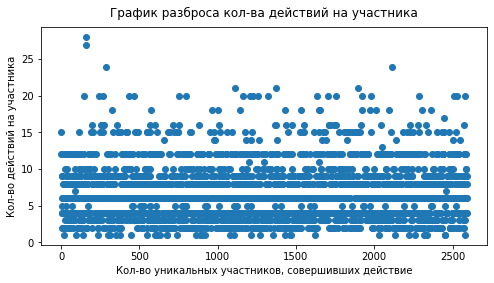

In [19]:
# проверка кол-в событий на пользователей на аномалии (очень активные пользователи)
test_groups_events_by_users = eu_recommender_test_events.groupby('user_id', as_index=False).agg({'event_name': 'count'})
display(test_groups_events_by_users.sort_values(by='event_name', ascending = False).head(3))
# построение графика разброса значений кол-ва действий на пользователя
x_values = pd.Series(range(0,len(test_groups_events_by_users)))
plt.figure(figsize=(8,4))
plt.scatter(x_values, test_groups_events_by_users['event_name'])
plt.title('График разброса кол-ва действий на участника',y=1.02)
plt.xlabel('Кол-во уникальных участников, совершивших действие')
plt.ylabel('Кол-во действий на участника')
plt.show()

<b>Выводы:</b><br>
При анализе кол-ва действий у самого активного пользователя 28 действий <br>
<br>
=> никого усключать не нужно - нет аномальных значений по кол-ву действий на пользователя <br>

<b> / Анализ периода между регистрацией и действием </b>

In [20]:
# добавление столбца с расчетом периода в днях между действием и датой регистрации
eu_recommender_test_events['days_period'] = (eu_recommender_test_events['event_date'] - eu_recommender_test_events['registation_date']).dt.days
# проверка корректности добавления 
display(eu_recommender_test_events.head(1))

,user_id,registation_date,region,device,group,ab_test,event_dt,event_name,details,event_date,days_period
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN,2020-12-07,0


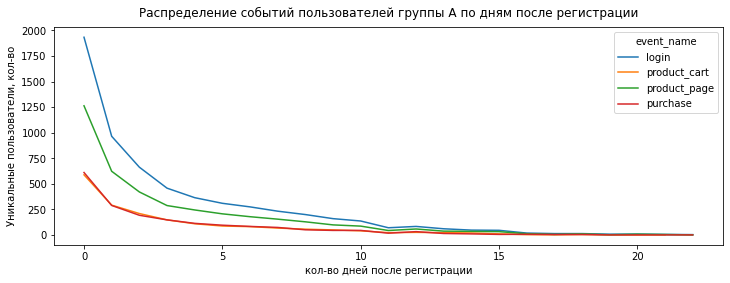

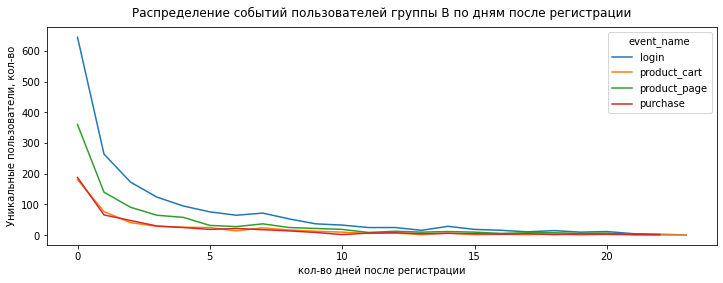

In [21]:
# анализ активности в днях (через сколько дней после регистрации пользователи совершают действие - из тех, кто совершил дейтствие)
# группа А
eu_recommender_test_events.query('group == "A"' ).pivot_table(
    index = 'days_period', columns = 'event_name', values = 'user_id', aggfunc = 'nunique').plot(figsize=(12,4))
plt.title('Распределение событий пользователей группы А по дням после регистрации', y= 1.02)
plt.xlabel('кол-во дней после регистрации')
plt.ylabel('Уникальные пользователи, кол-во')
plt.show()
# группа В
eu_recommender_test_events.query('group == "B"' ).pivot_table(
    index = 'days_period', columns = 'event_name', values = 'user_id', aggfunc = 'nunique').plot(figsize=(12,4))
plt.title('Распределение событий пользователей группы В по дням после регистрации', y= 1.02)
plt.xlabel('кол-во дней после регистрации')
plt.ylabel('Уникальные пользователи, кол-во')
plt.show()

<b>Выводы:</b><br>
Среди участников теста, которые совершили какое-либо действие, большинство участников совершают действие в первые 10 дней после регистрации

<b> / Анализ действий по дням периода </b>

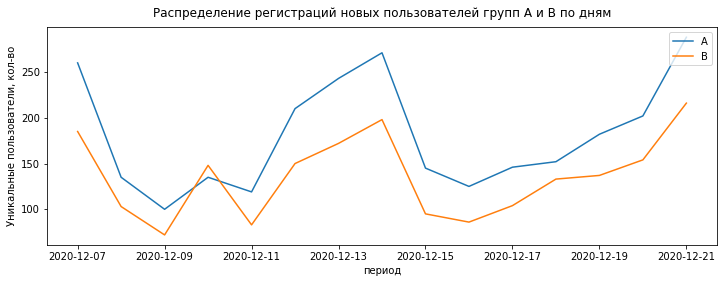

In [22]:
# анализ регистраций пользователей групп А и В по дням проведения А/В теста
eu_recommender_test_users.pivot_table(
    index='registation_date',columns='group',values='user_id',aggfunc='nunique').plot(figsize=(12,4))
plt.title('Распределение регистраций новых пользователей групп А и В по дням', y= 1.02)
plt.xlabel('период')
plt.ylabel('Уникальные пользователи, кол-во')
plt.legend(loc='upper right')
plt.show()

<b>Выводы:</b><br>
Регистрации пользователей групп А и В одинаково распределены по дням (единый тренд у 2х групп) <br>
=> Набор участников проведен корректно: участники групп А и В равномерно регистрировались все дни набора участников <br>

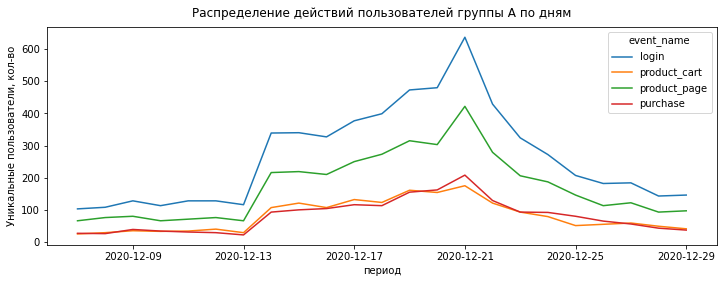

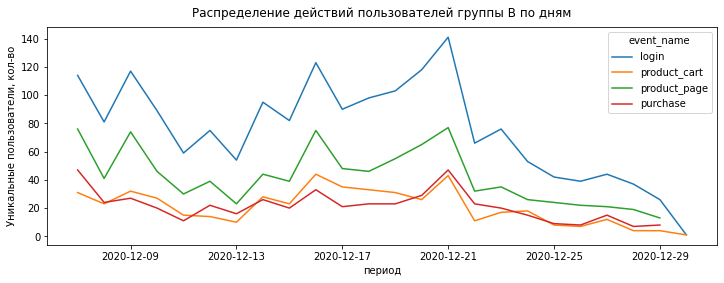

In [23]:
# анализ активности пользователей групп А и В по дням проведения А/В теста
# действия группы А
eu_recommender_test_events.query('group == "A"' ).pivot_table(
    index='event_date',columns='event_name',values='user_id',aggfunc='nunique').plot(figsize=(12,4))
plt.title('Распределение действий пользователей группы А по дням', y= 1.02)
plt.xlabel('период')
plt.ylabel('Уникальные пользователи, кол-во')
plt.show()
# действия группы В
eu_recommender_test_events.query('group == "B"' ).pivot_table(
    index='event_date',columns='event_name',values='user_id',aggfunc='nunique').plot(figsize=(12,4))
plt.title('Распределение действий пользователей группы B по дням', y= 1.02)
plt.xlabel('период')
plt.ylabel('Уникальные пользователи, кол-во')
plt.show()

<b>Выводы:</b><br>
- действия пользователей группы А сосредоточены в районе 17 - 21 декабря - скорее всего, это связано с сезонной активностю пользователей (на пользователях группы А не было тестирования новой рекомендательной системы)<br>
- действия пользователей группы В равномерно распределены по дням проведения теста <br>

<b> / Конверсия </b>

In [24]:
# нахождение конверсии в действие 
# создание таблицы кол-ва пользователей по регистрациям и группам
test_groups_registrations = eu_recommender_test_users.pivot_table(columns = 'group', values = 'user_id', aggfunc = 'nunique')
test_groups_registrations.columns = ['group_A', 'group_B']
test_groups_registrations = test_groups_registrations.rename(index={ 'user_id': 'registrations'})
# создание таблицы  кол-ва пользователей по действиям и группам
test_groups_events = eu_recommender_test_events.pivot_table(
    index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')
test_groups_events.columns = ['group_A', 'group_B']
# объединенение в единую таблицу
test_groups = test_groups_registrations.append(test_groups_events)
test_groups['total'] = test_groups['group_A'] + test_groups['group_B']
display(test_groups.sort_values(by='total',ascending = False))

,group_A,group_B,total
registrations,2713,2036,4749
login,1939,655,2594
product_page,1265,367,1632
purchase,613,191,804
product_cart,589,184,773


<b>Выводы:</b><br>
Действия пользователей после регистрации распределены следующим образом:<br>
1.Авторизация ('login')<br>
2.Просмотр страницы товара ('product_page') <br>
3.Покупка ('purchase') <br>
4.Добавление в корзину ('product_cart')<br>
<br>
Операций 'Авторизация' ('login') больше, чем 'Просмотр страницы товара' ('product_page') => вероятно, требуется несколько авторизаций в процессе покупок => данное событие не будет учитываться в конверсии в продажи <br>
Действий 'Покупка' ('purchase') больше чем действий 'Добавление в корзину' ('product_cart') => возможна покупка в 1 клик со страницы товара<br>
<br>
На основании данных по действиям - основное действие после Регистрации для анализа Воронки продаж: 'Просмотр страницы товара' ('product_page')

<b>Промежуточная оценка кол-ва участников теста :</b><br>
На основании конверсии действия "Регистрация" в действие "Просмотр страницы товара" необходимо рассчитать минимальное кол-во пользователей для нахождения статистической значимости различий показателей групп<br>
Расчет конверсии будет по показателям 2х групп:<br>
"Регистрация": общее кол-во 4749<br>
"Просмотр страницы товара": общее кол-во 1632<br>
<br>
Целевой показатель минимального кол-ва участников: показатель группы А: 1265 участников, показатель группы В: 367 участников <br>

In [25]:
# рассчитаем конверсию всех пользователей теста на основании регистраций и действия "просмотр страницы товара" ('product_page')
print('Конверсия Регистраций в Просмотр страницы товара (все участники теста), %:', round(test_groups.loc['product_page','total'] / test_groups.loc['registrations', 'total'],3))

Конверсия Регистраций в Просмотр страницы товара (все участники теста), %: 0.344


<b> / Оценка кол-ва участников для достижения статистической значимости

Тест: https://www.evanmiller.org/ab-testing/sample-size.html <br>
Baseline conversion rate: 34%  (конверсия в действие, %) <br>
Minimum Detectable Effect: 10%  (ожидаемый эффект, %)<br>
Statistical power 1−β: 80% (мощность, %) <br>
Significance level α:  5%  (alpha, %) <br>
<b> Absolute: 357 per variation  (итоговое кол-во в абсолюте) </b><br>
<br>
Тест: https://mindbox.ru/academy/ab-test-calculator/  <br>
Средний показатель: 34%<br>
Ожидаемый абсолютный прирост: 10%   <br>
Мощность: 80%   <br> 
Достоверность: 95%<br>
<b> В каждом варианте: 352   </b><br> 

<div class="alert alert-info">
    <b>Выводы по минимальному кол-ву участников А/В-теста:</b><br>
Кол-во участников в группе B (367 пользователей с действием "просмотр страницы товара") достаточно для оценки статистической значимости показателей теста 

<b>/ Анализ воронки продаж </b>

Для анализа Воронки продаж из действий пользователей исключены события:
- 'Авторизация' ('login'), так как превышает кол-во действий 'Просмотр страницы товара' (вероятно, требуется несколько операций авторизаций для совершения покупки)
- 'Добавление в корзину' ('product_cart'), так как возможна покупка со станицы товара (действий покупка больше, чем действий добавление в корзину)<br> 

In [26]:
# отображение данных по событиям воронки продаж
ab_test_purchase = test_groups.sort_values(by='total',ascending = False)
ab_test_purchase = ab_test_purchase.drop(['login','product_cart']).reset_index()
# нахождение конверсии к предыдущему шагу воронки
ab_test_purchase['A_to_previous'] = round(ab_test_purchase['group_A'] / ab_test_purchase['group_A'].shift(1),3)
ab_test_purchase['B_to_previous'] = round(ab_test_purchase['group_B'] / ab_test_purchase['group_B'].shift(1),3)
# нахождение конверсии к первому шагу
ab_test_purchase['A_to_initial'] = round(ab_test_purchase['group_A'] / ab_test_purchase['group_A'].shift(2),3)
ab_test_purchase['B_to_initial'] = round(ab_test_purchase['group_B'] / ab_test_purchase['group_B'].shift(2),3)
# нахождение разницы
ab_test_purchase['Diff_B_to_A_to_previous'] = round(ab_test_purchase['B_to_previous'] - ab_test_purchase['A_to_previous'],3)
ab_test_purchase['Diff_B_to_A_to_initial'] = round(ab_test_purchase['B_to_initial'] - ab_test_purchase['A_to_initial'],3)
display(ab_test_purchase)

,index,group_A,group_B,total,A_to_previous,B_to_previous,A_to_initial,B_to_initial,Diff_B_to_A_to_previous,Diff_B_to_A_to_initial
0,registrations,2713,2036,4749,NaN,NaN,NaN,NaN,NaN,NaN
1,product_page,1265,367,1632,0.466,0.18,NaN,NaN,-0.286,NaN
2,purchase,613,191,804,0.485,0.52,0.226,0.094,0.035,-0.132


<b>Выводы:</b><br>
Разница долей в конверсиях по воронке:<br>
Просмотр страницы товара к регистрациям: группа В хуже группы А на 29 п.п.<br>
Покупка к просмотру страницы товара: группа В лучше группы А на 3,5 п.п.<br>
Покупка к регистрациям: группа В хуже группы А на 13 п.п.<br>
<br>
=> необходимо подтверждение статистической значимости разниц долей

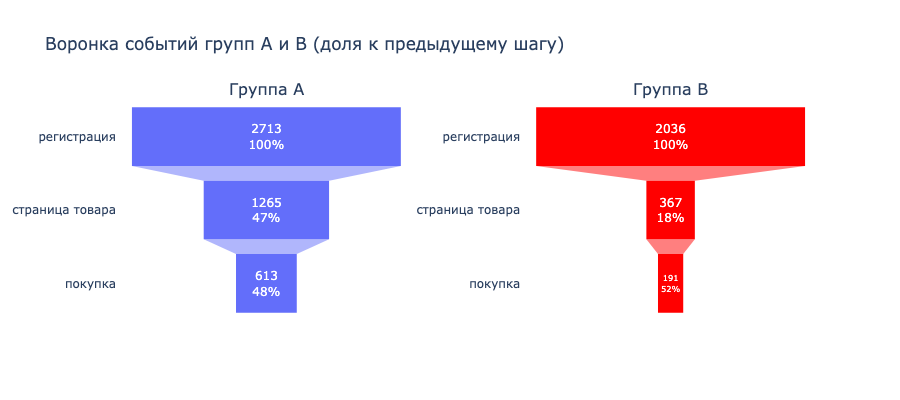

In [27]:
# визуализация воронки продаж по группам
fig = make_subplots(rows=1, cols=2,subplot_titles=("Группа А","Группа В"), horizontal_spacing = 0.15)
fig.add_trace(go.Funnel(
    y = ["регистрация", "страница товара", "покупка"],
    x = [ab_test_purchase.loc[0,'group_A'], ab_test_purchase.loc[1,'group_A'], ab_test_purchase.loc[2,'group_A']],
    textposition = "inside",
    textinfo = "value+percent previous",), row=1, col=1)
fig.add_trace(go.Funnel(
    y = ["регистрация", "страница товара", "покупка"],
    x = [ab_test_purchase.loc[0,'group_B'], ab_test_purchase.loc[1,'group_B'], ab_test_purchase.loc[2,'group_B']],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": "#ff0000"}),row=1, col=2)
fig.update_layout(
    height=350, width=950,
    title_text='Воронка событий групп А и В (доля к предыдущему шагу)',
    showlegend=False,
    plot_bgcolor = "rgba(0,0,0,0)")
fig.show(renderer='png', width = 900, height = 400)

In [28]:
# анализ среднего чека по группам
avg_purchase = eu_recommender_test_events.query('event_name == "purchase"' ).pivot_table(
    index='group',values='details',aggfunc=['mean','min','max'])
avg_purchase.columns = (['avg_purchase','min_purchase','max_purchase'])
avg_purchase['avg_purchase'] = round(avg_purchase['avg_purchase'],3)
display(avg_purchase)

,avg_purchase,min_purchase,max_purchase
group,,,
A,22.951,4.99,499.99
B,21.488,4.99,499.99


<b>Выводы:</b><br>
Разница в среднем чеке у групп А и В незначительная <br>
Отстутствует разница в стоимости минимальной/максимальной покупки у групп А и В <br>

<div class="alert alert-info">
<b>Вывод по результатам А/В теста:</b> <br>

<br>
Итоговое кол-во участников теста: 4749<br>
<br>
В группе А действие после регистрации совершили 72% участников<br>
В группе В действие после регистрации совершили 32% участников <br>
45% участников теста не совершили никакого действия после регистрации<br>
Среднее кол-во событий на пользователя у участников составляет: 7 событий у группы А, 5.7 событий у группы В составляет  <br>
<br>    
Регистрации пользователей групп А и В одинаково распределены по дням (единый тренд у 2х групп) <br>
=> Набор участников проведен корректно: участники групп А и В равномерно регистрировались все дни набора участников <br>
<br> 
На основании данных по действиям составлены события Воронки продаж:<br> 
1. Регистрация ('registation_date')<br> 
2. Просмотр страницы товара ('product_page')<br> 
3. Покупка ('purchase’)<br> 
<br>
Исключены из событий Воронки продаж действия:<br> 
- 'Авторизация' ('login'), так как превышает кол-во действий 'Просмотр страницы товара' (вероятно, требуется несколько операций авторизаций для совершения покупки)<br> 
- 'Добавление в корзину' ('product_cart'), так как возможна покупка со станицы товара (действий покупка больше, чем действий добавление в корзину)<br>     
<br>     
Конверсия регистраций участников 2-х групп в просмотр страницы товара: 34% <br> 
<br> 
Проведена оценка минимального кол-ва участников для достижения статистической значимости: кол-во участников теста достаточно для оценки статистической значимости показателей  <br>

### Анализ статистической значимости

<b>/ Формирование гипотез <b>

Гипотезы для проверки:  <br>
Нулевая гипотеза (H0): различий в конверсии (доли переходов) по этапам воронки между группами А и В нет <br>
Альтернативная (H1): между группами разная конверсия (доля переходов) по этапам воронки <br>
<br>
Уровень значимости для рачета различий (alpha): 5% (доля ошибки в 5%) <br>
<br>
Результат нахождения p-значения:<br>
- p-value > значения alpha => нулевая гипотеза верна, нет оснований считать доли (конверсии) разными <br>
- p-value < значения alpha => нулевую гипотезу отвергаем, между долями (конверсиями) групп есть статистически значимая разница 

In [29]:
# функция расчета p-value для нахождения статистически значимого различия долей
def stats (group_1_trials, group_1_successes, group_2_trials, group_2_successes):
    p1 = group_1_successes/group_1_trials
    p2 = group_2_successes/group_2_trials
    p_combined = (group_1_successes + group_2_successes) / (group_1_trials + group_2_trials)
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_1_trials + 1/group_2_trials))
    distr = st.norm(0, 1)  
    p_value = ((1 - distr.cdf(abs(z_value))) * 2)
    return p_value
# функция сравнения значения p-value с уровнем значимости alpha = 5%
def pvalue_05 (test):
    alpha = 0.05
    if test < alpha: print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else: print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    return 

In [30]:
# формирование групп для анализа
group_A_registrations = eu_recommender_test_users.query('group == "A"' )['user_id'].nunique()
group_A_product_page = eu_recommender_test_events.query('group == "A" and event_name == "product_page"')['user_id'].nunique()
group_A_purchase = eu_recommender_test_events.query('group == "A" and event_name == "purchase"')['user_id'].nunique()
group_B_registrations = eu_recommender_test_users.query('group == "B"' )['user_id'].nunique()
group_B_product_page = eu_recommender_test_events.query('group == "B" and event_name == "product_page"')['user_id'].nunique()
group_B_purchase = eu_recommender_test_events.query('group == "B" and event_name == "purchase"')['user_id'].nunique()
# прверка корректности формирования групп
print('Кол-во участников в группах А и В:',group_A_registrations, group_A_product_page, group_A_purchase, group_B_registrations, group_B_product_page, group_B_purchase)

Кол-во участников в группах А и В: 2713 1265 613 2036 367 191


<b>/ Проверка статистически значимой разницы долей у групп А и В <b>

In [31]:
# проверки разницы долей
print('Просмотр страницы товара к регистрациям: различие долей групп А/В')
test_product_page_to_registration_AB = stats(group_A_registrations,group_A_product_page,group_B_registrations,group_B_product_page)
print('p-значение: ', round(test_product_page_to_registration_AB,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_product_page_to_registration_AB))
print()
print('Покупка к просмотру страницы товара: различие долей групп А/В')
test_purchase_to_product_page_AB = stats(group_A_product_page,group_A_purchase,group_B_product_page,group_B_purchase)
print('p-значение: ', round(test_purchase_to_product_page_AB,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_purchase_to_product_page_AB))
print()
print('Покупка к регистрациям: различие долей групп А/В')
test_purchase_to_registration_AB = stats(group_A_registrations,group_A_purchase,group_B_registrations,group_B_purchase)
print('p-значение: ', round(test_purchase_to_registration_AB,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_purchase_to_registration_AB))

Просмотр страницы товара к регистрациям: различие долей групп А/В
p-значение:  0.0
Результат при alpha 5%:
Отвергаем нулевую гипотезу: между долями есть значимая разница
None

Покупка к просмотру страницы товара: различие долей групп А/В
p-значение:  0.22648
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Покупка к регистрациям: различие долей групп А/В
p-значение:  0.0
Результат при alpha 5%:
Отвергаем нулевую гипотезу: между долями есть значимая разница
None


<b> Выводы: </b> <br>
Результаты нахождения статистически значимой разницы долей между группами А/В с уровнем значимости alpha = 5%:<br>
Было проведено 3 теста для разных событий: <br>
- Доля просмотра страницы товара от зарегистрированных пользователей: - найдено статистически значимое различие<br>
- Доля покупок от просмотров страницы товара: - не найдено статистически значимое различие<br>
- Доля покупок от зарегистрированных пользователей: - найдено статистически значимое различие<br>

<div class="alert alert-info">
<b>Вывод по различиям групп А/В-теста:</b> <br>
<br>    
Проведен различия долей групп А и В с уровнем значимости alpha = 5%: <br>
<br>
- обнаружено статистически значимое различие долей перехода от Регистрации к Просмотру товара<br>
- обнаружено статистически значимое различие долей перехода от Регистрации к Покупкам<br>
=> пользователи групп А и В по разному совершают Просмотр страницы товара / Покупки после Регистрации (разницу в долях переходов можно считать значимой)<br>
<br>    
- не обнаружено статистически значимого различия долей перехода от Просмотров страницы товара к Покупкам<br>
=> пользователи групп А и В одинаково совершают Покупки после Просмотра страгницы товара (разницу в долях переходов нельзя считать значимой)

### Общий вывод

Проведен анализ А/В-теста recommender_system_test.<br>
По полученным данным можно сделать выводы:<br>
<br>
<b> 1. Набор участников теста соответствует Техническому заданию</b>  <br>
-в тесте участвуют группы А и В<br>
-дата регистраций участников и событий участников были в период, указанный в Техническом задании<br>
-собраны данные по 6351 участнике теста, что составляет 15% новых пользователей региона EU<br>
-набор участников теста проведен корректно: участники групп А и В равномерно регистрировались все дни набора участников<br>
<br>
<b> 2. Кол-во участников теста достаточно для нахождения статистической значимости различий у групп</b><br>
-итоговое кол-во участников теста после проверок: 4749<br>
-данное кол-во участников теста достаточно для оценки статистической значимости показателей<br>
<br>
<b> 3. Результаты групп А и В отличаются</b><br>
Результаты группы В хуже показателей группы А:<br>
-у группы В больше неактивных участников<br>
-у группы В меньше действий на пользоватя<br>
-у группы В хуже показатели конверсии Регистраций в Просмотр страницы товара (подтверждено статистической значимостью различий долей)<br>
-у группы В хуже показатели конверсии Регистраций в Покупки (подтверждено статистической значимостью различий долей)<br>
<br>
<b>На основании анализа А/В-теста  можно сделать выводы:</b><br>
При тестировании новой платёжной воронки (recommender_system_test) не получилось достичь ожидаемый эффект: <br>
=> показатели пользователей новой платёжнаой воронки хуже, чем у пользователей без изменений пути покупки<br>